In [50]:
import pandas as pd
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset

In [51]:
movie_df = pd.read_csv('../data/tmdb_5000_movies.csv')
credits_df = pd.read_csv('../data/tmdb_5000_credits.csv')

In [52]:
df = pd.merge(movie_df, credits_df, left_on = 'id', right_on = 'movie_id')
raw_dataset = df.copy()

# data exploration

In [53]:
# Shape of the dataset
shape = df.shape

# Data types of the columns
data_types = df.dtypes

# Check for missing values
missing_values = df.isnull().sum()

# Descriptive statistics of the numerical columns
descriptive_stats = df.describe()

# Count of unique values for each column
unique_counts = df.nunique()

In [54]:
shape, data_types, missing_values, descriptive_stats, unique_counts

((4803, 24),
 budget                    int64
 genres                   object
 homepage                 object
 id                        int64
 keywords                 object
 original_language        object
 original_title           object
 overview                 object
 popularity              float64
 production_companies     object
 production_countries     object
 release_date             object
 revenue                   int64
 runtime                 float64
 spoken_languages         object
 status                   object
 tagline                  object
 title_x                  object
 vote_average            float64
 vote_count                int64
 movie_id                  int64
 title_y                  object
 cast                     object
 crew                     object
 dtype: object,
 budget                     0
 genres                     0
 homepage                3091
 id                         0
 keywords                   0
 original_language          0

* Count of empty lists for each column

In [55]:
empty_list_counts = {}

for column in df.columns:
    if df[column].apply(lambda x: isinstance(x, list)).any():
        empty_list_counts[column] = sum(df[column].apply(lambda x: len(x) == 0))

for column, count in empty_list_counts.items():
    print(f"Column '{column}' has {count} empty lists.")

In [56]:
df.shape

(4803, 24)

# Data Cleaning

In [57]:
def has_http(value):
    if isinstance(value, str) and 'http' in value:
        return 1
    else:
        return 0


df.loc[:, 'has_homepage'] = df['homepage'].apply(lambda x: has_http(x))
del df['homepage']

- Standardize Text Data and datetime and Normalization and Scaling

In [58]:
df["release_date"] = pd.to_datetime(df["release_date"])

# Extract year, month, day, and day of week
df["year"] = df["release_date"].dt.year
df["month"] = df["release_date"].dt.month
df["day"] = df["release_date"].dt.day
df["dow"] = df["release_date"].dt.dayofweek

In [59]:
df['title_x'] = df['title_x'].str.lower()  # Convert titles to lowercase

df['popularity_normal'] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min())

- handling missing values

In [60]:
from sklearn.impute import SimpleImputer

runtime_median = df[df['runtime'] != 0]['runtime'].median()

# Replace NaN with the median
imputer_med = SimpleImputer(strategy='constant', fill_value=runtime_median)
df['runtime'] = imputer_med.fit_transform(df[['runtime']])

# Replace 0 values with the median
df.loc[df['runtime'] == 0, 'runtime'] = runtime_median


In [61]:
budget_median = df[df['budget'] != 0]['budget'].median()

# Replace 0 values with the median
df.loc[df['budget'] < 100, 'budget'] = budget_median

In [62]:
revenue_median = df[df['revenue'] != 0]['revenue'].median()

# Replace 0 values with the median
df.loc[df['revenue'] < 60, 'revenue'] = revenue_median

In [63]:
# Filter out zeros
filtered_column = df[df['vote_average'] != 0]['vote_average']  
mode_without_zeros = filtered_column.mode()[0]

df.loc[df['vote_average'] == 0, 'vote_average'] = mode_without_zeros

In [64]:
# Filter out zeros
filtered_column = df[df['vote_count'] != 0]['vote_count']  
mode_without_zeros = filtered_column.mode()[0]

df.loc[df['vote_count'] == 0, 'vote_count'] = mode_without_zeros

- replacing overviews where is none

In [65]:
df.loc[df['id'] == 370980, 'overview'] = 'Following the rise of father Jorge Mario Bergoglio from his early life as a teacher in a Jesuit High School in Argentina, to archbishop and cardinal of Buenos Aires, until he was elected Pope of the Roman Catholic Church.'

df.loc[df['id'] == 459488, 'overview'] = 'An exploration of how singer and actor Frank Sinatra became one of the biggest stars of the 20th century while remaining, in his heart, a normal person.'


In [66]:
df.drop_duplicates(inplace=True)

df.drop(
    columns=['release_date', 'status', 'original_title', 'tagline', 'movie_id',
             'title_y'], inplace=True)

df = df.reindex(
    columns=['id', 'title_x', 'original_language', 'spoken_languages', 'genres',
             'keywords', 'overview', 'production_companies', 'production_countries', 'year',
             'month', 'day', 'dow', 'revenue', 'budget', 'runtime',
             'popularity', 'has_homepage', 'cast', 'crew', 'vote_count',
             'vote_average', 'profit'])

In [67]:
df = df[df['id'] != 380097]

~ Dealing with JSON Fields

In [68]:
# Parsing the genres column from JSON format
df['genres'] = df['genres'].apply(
    lambda x: [genre['name'] for genre in json.loads(x)])

df['keywords'] = df['keywords'].apply(
    lambda x: [key['name'] for key in json.loads(x)])

df['production_companies'] = df['production_companies'].apply(
    lambda x: [company['name'] for company in json.loads(x)])

df['production_countries'] = df['production_countries'].apply(
    lambda x: [country['name'] for country in json.loads(x)])

df['spoken_languages'] = df['spoken_languages'].apply(
    lambda x: [language['iso_639_1'] for language in json.loads(x)])

In [76]:
df

,id,title_x,original_language,spoken_languages,genres,keywords,overview,production_companies,production_countries,year,...,revenue,budget,runtime,popularity,has_homepage,cast,crew,vote_count,vote_average,profit
0,19995,avatar,en,"[en, es]","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009.0,...,2787965087,237000000,162.0,150.437577,1,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, James Cameron, ...",11800,7.2,2550965087
1,285,pirates of the caribbean: at world's end,en,[en],"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007.0,...,961000000,300000000,169.0,139.082615,1,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...",4500,6.9,661000000
2,206647,spectre,en,"[fr, en, es, it, de]","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015.0,...,880674609,245000000,148.0,107.376788,1,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]",4466,6.3,635674609
3,49026,the dark knight rises,en,[en],"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",Following the death of District Attorney Harve...,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012.0,...,1084939099,250000000,165.0,112.312950,1,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Charles Roven, Christopher Nolan, Christopher...",9106,7.6,834939099
4,49529,john carter,en,[en],"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","John Carter is a war-weary, former military ca...",[Walt Disney Pictures],[United States of America],2012.0,...,284139100,260000000,132.0,43.926995,1,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Colin Wilson, Jim Morris, Lin...",2124,6.1,24139100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,el mariachi,es,[es],"[Action, Crime, Thriller]","[united states–mexico barrier, legs, arms, pap...",El Mariachi just wants to play his guitar and ...,[Columbia Pictures],"[Mexico, United States of America]",1992.0,...,2040920,220000,81.0,14.269792,0,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua...","[Robert Rodriguez, Robert Rodriguez, Carlos Ga...",238,6.6,1820920
4799,72766,newlyweds,en,[],"[Comedy, Romance]",[],A newlywed couple's honeymoon is upended by th...,[],[],2011.0,...,51751835,9000,85.0,0.642552,0,"[Edward Burns, Kerry Bishé, Marsha Dietlein, C...","[Edward Burns, Edward Burns, Edward Burns, Wil...",5,5.9,51742835
4800,231617,"signed, sealed, delivered",en,[en],"[Comedy, Drama, Romance, TV Movie]","[date, love at first sight, narration, investi...","""Signed, Sealed, Delivered"" introduces a dedic...","[Front Street Pictures, Muse Entertainment Ent...",[United States of America],2013.0,...,51751835,23000000,120.0,1.444476,1,"[Eric Mabius, Kristin Booth, Crystal Lowe, Geo...","[Harvey Kahn, Martha Williamson, Scott Smith]",6,7.0,28751835
4801,126186,shanghai calling,en,[en],[],[],When ambitious New York attorney Sam is sent t...,[],"[United States of America, China]",2012.0,...,51751835,23000000,98.0,0.857008,1,"[Daniel Henney, Eliza Coupe, Bill Paxton, Alan...","[Daniel Hsia, Daniel Hsia]",7,5.7,28751835


In [71]:
def json_convert(obj):
    l=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter !=10:
            l.append(i['name'])
            counter+=1
        else:
            break
    return l

df['cast']=df['cast'].apply(json_convert)

ValueError: malformed node or string: ['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver', 'Stephen Lang', 'Michelle Rodriguez', 'Giovanni Ribisi', 'Joel David Moore', 'CCH Pounder', 'Wes Studi', 'Laz Alonso']

In [73]:
def fetch_crew(obj):
    l=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director' or i['job']=='Writer' or i['job']=='Producer':
            l.append(i['name'])
    return l


df['crew']=df['crew'].apply(fetch_crew)

+ creating Profit column

In [75]:
df['profit'] = df['revenue'] - df['budget']

# visualizitaion

C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\3517913182.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette=current_palette )
C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\3517913182.py:6: UserWarning: 
The palette list has fewer values (10) than needed (87) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=language_counts.index, y=language_counts.values, palette=current_palette )


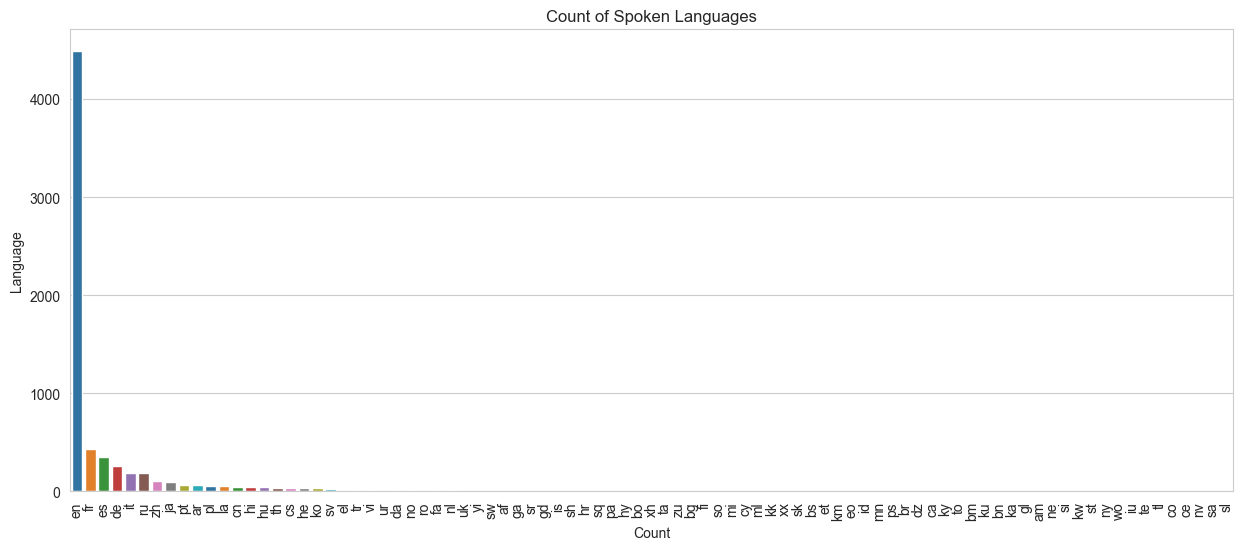

In [244]:
# Count the occurrences of each language
language_counts = df['spoken_languages'].explode().value_counts()

current_palette = sns.color_palette() 
plt.figure(figsize=(15, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette=current_palette )
plt.title('Count of Spoken Languages')
plt.xlabel('Count')
plt.ylabel('Language')
plt.xticks(rotation=90)
plt.show()

C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\698886890.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="original_language", data=df, palette=current_palette)
C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\698886890.py:2: UserWarning: 
The palette list has fewer values (10) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x="original_language", data=df, palette=current_palette)


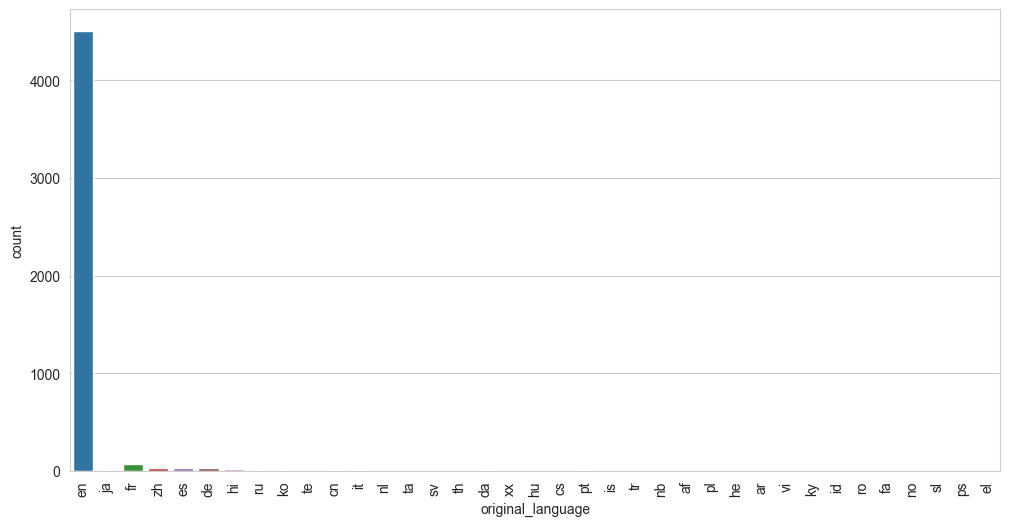

In [245]:
plt.figure(figsize=(12, 6))
sns.countplot(x="original_language", data=df, palette=current_palette)
plt.xticks(rotation=90)
plt.show()

~ Correlation Heatmap

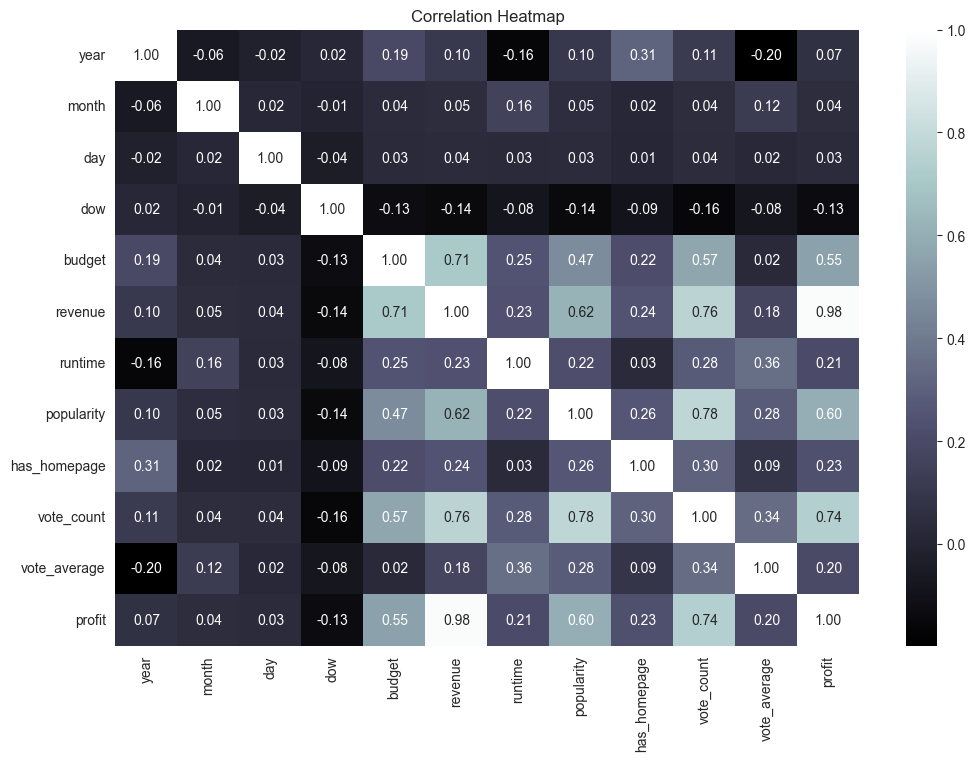

In [246]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['year', 'month', 'day', 'dow', 'budget', 'revenue', 'runtime', 'popularity', 'has_homepage', 'vote_count', 'vote_average','profit']].corr(), annot=True, cmap='bone', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

~ Boxplot

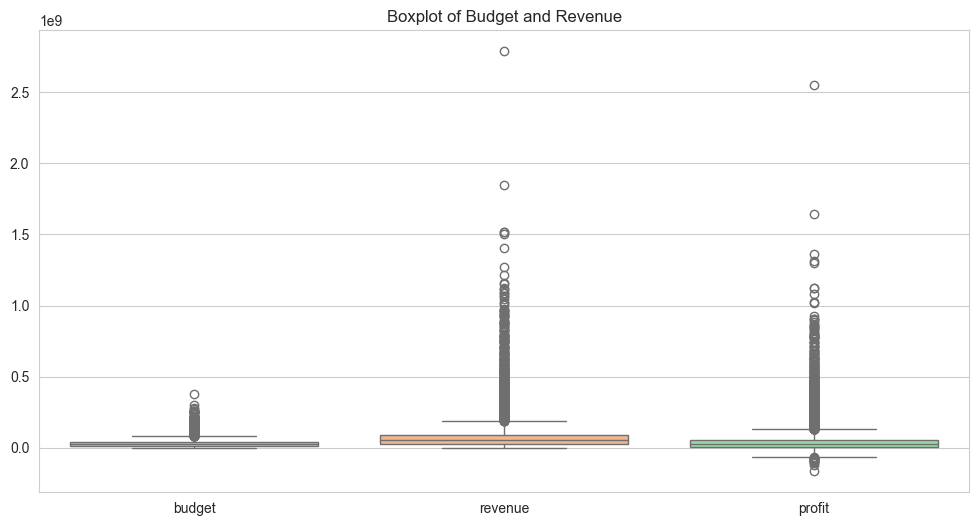

In [247]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['budget', 'revenue', 'profit']], palette='pastel')
plt.title('Boxplot of Budget, Revenue and profit')
plt.show()

~ Bar Plot for Genres

C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\3511931928.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='rocket')


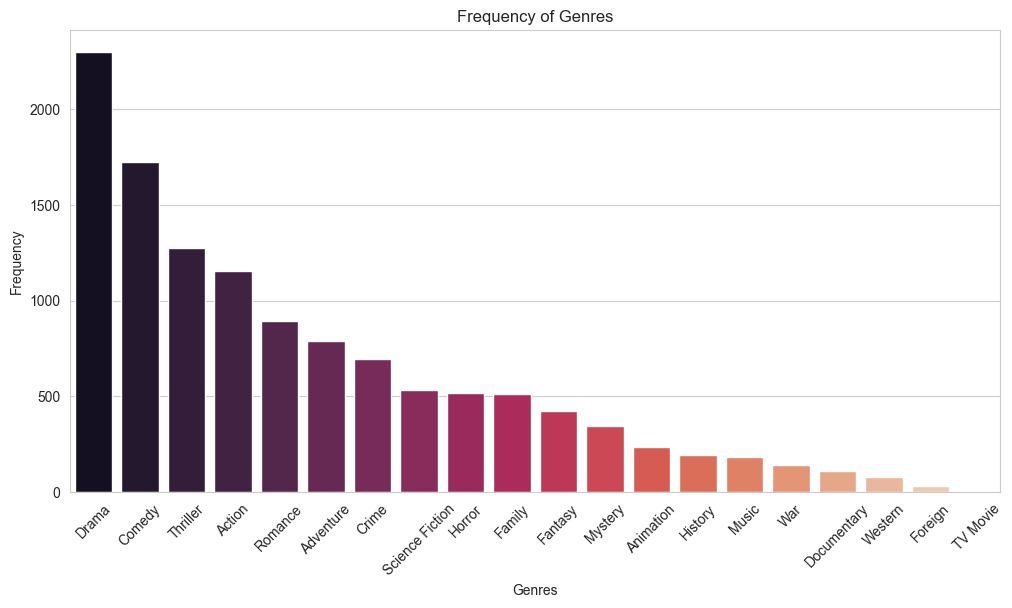

In [248]:
plt.figure(figsize=(12, 6))
genre_counts = df['genres'].explode().value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='rocket')
plt.title('Frequency of Genres')
plt.xlabel('Genres')
plt.ylabel('Frequency')
(plt.xticks
(rotation=45))
plt.show()

~ Bar Plot for Original Language

C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\3950856219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='profit', data=profits_per_year, palette=current_palette)
C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\3950856219.py:6: UserWarning: 
The palette list has fewer values (10) than needed (90) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='year', y='profit', data=profits_per_year, palette=current_palette)


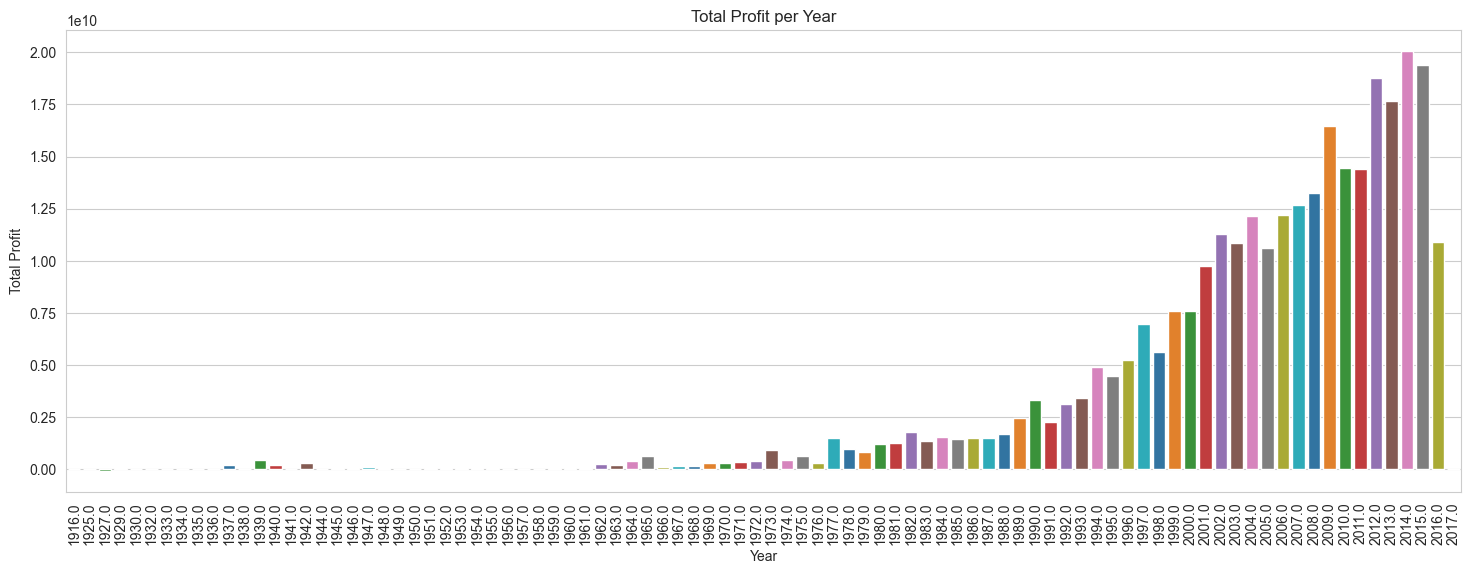

In [250]:
# Group by year and sum profit
profits_per_year = df.groupby("year")["profit"].sum().reset_index()

# Plot the barplot
plt.figure(figsize=(18, 6))
sns.barplot(x='year', y='profit', data=profits_per_year, palette=current_palette)
plt.xlabel('Year')
plt.ylabel('Total Profit')
plt.title('Total Profit per Year')
plt.xticks(rotation=90)
plt.show()

- Day of week release

C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\819902607.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days,y='profit',data=profit_by_dow, palette=current_palette)
C:\Users\ROG\AppData\Local\Temp\ipykernel_12784\819902607.py:3: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x=days,y='profit',data=profit_by_dow, palette=current_palette)


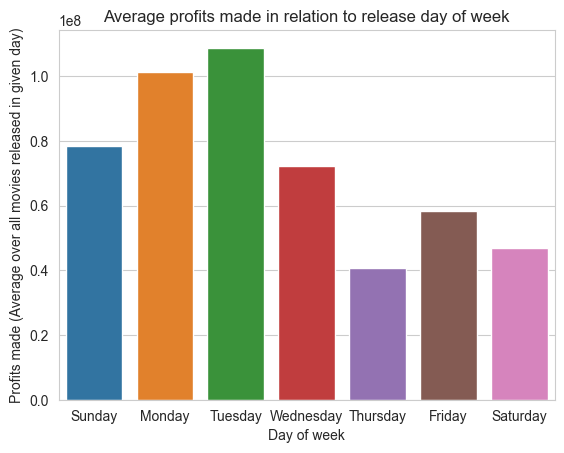

In [286]:
profit_by_dow = df[df["year"]>1990].groupby(["dow"]).profit.mean().reset_index()
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
sns.barplot(x=days,y='profit',data=profit_by_dow, palette=current_palette)
plt.xlabel('Day of week')
plt.ylabel('Profits made (Average over all movies released in given day)')
plt.title('Average profits made in relation to release day of week')
plt.show()

~ Histogram

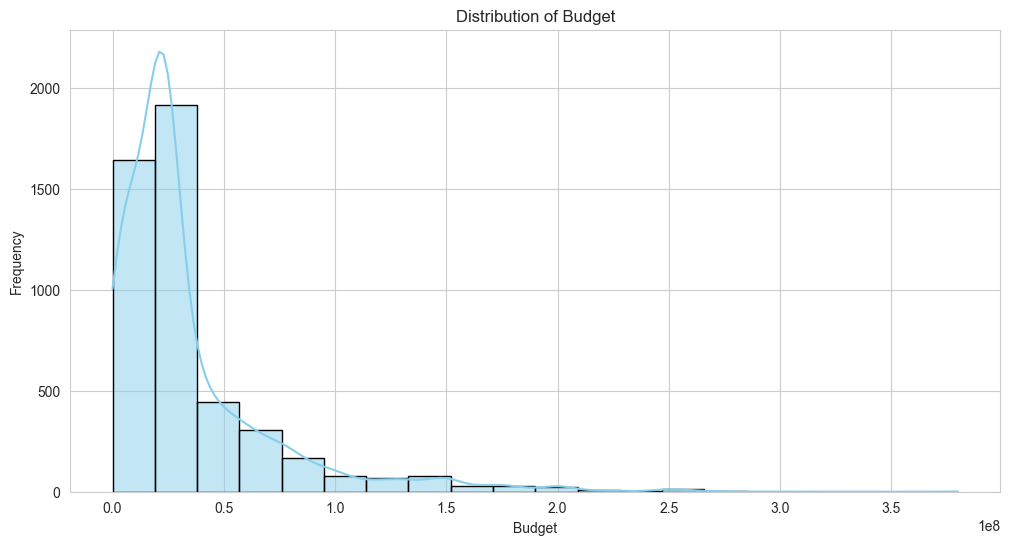

In [285]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='budget', kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

~ Scatter Plot

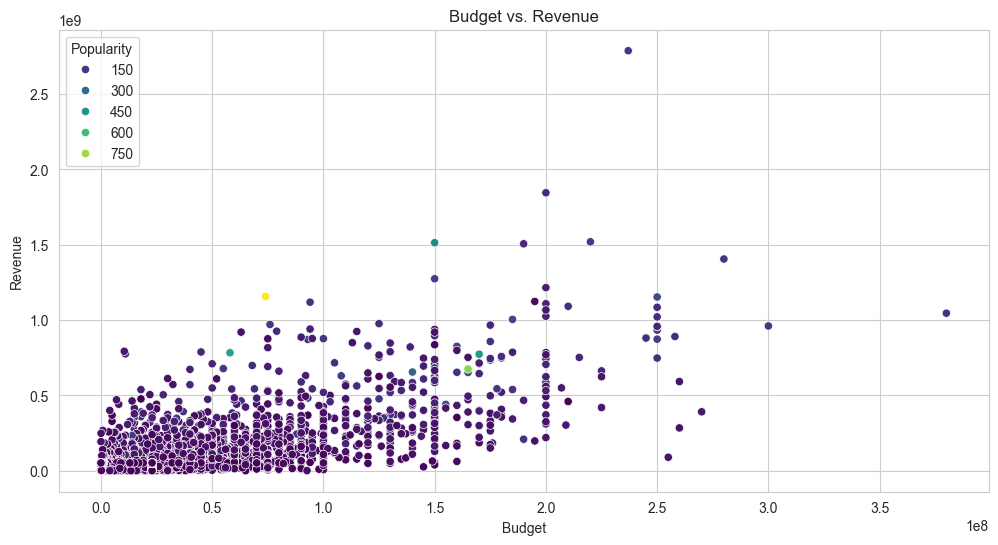

In [253]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='budget', y='revenue', hue='popularity', palette='viridis', legend='brief')
plt.title('Budget vs. Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.legend(title='Popularity', loc='upper left')
plt.show()

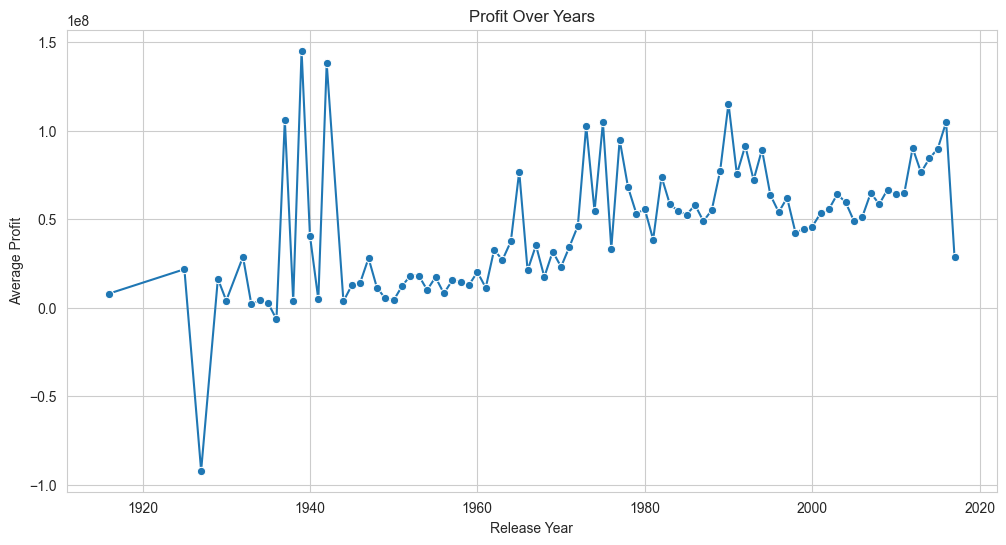

In [84]:
# Time Series Plot of Profit Over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='profit', data=df.groupby('year')['profit'].mean().reset_index(),
             marker='o')
plt.title('Profit Over Years')
plt.xlabel('Release Year')
plt.ylabel('Average Profit')
plt.show()

locate the movie with the max runtime

In [224]:
max_runtime_id = df["runtime"].idxmax() 
print(df.loc[max_runtime_id][['title_x','runtime','year', 'overview']])

title_x                                                carlos
runtime                                                 338.0
year                                                   2010.0
overview    The story of Venezuelan revolutionary, Ilich R...
Name: 2384, dtype: object


Most popular Movie

In [99]:
pop = df["popularity"].idxmax()
most_popular_movie = df.loc[pop]
print(df.loc[pop][['title_x','profit','year','vote_average', 'crew']])

title_x                                                   minions
profit                                                 1082730962
year                                                       2015.0
vote_average                                                  6.4
crew            [Christopher Meledandri, Kyle Balda, Janet Hea...
Name: 546, dtype: object


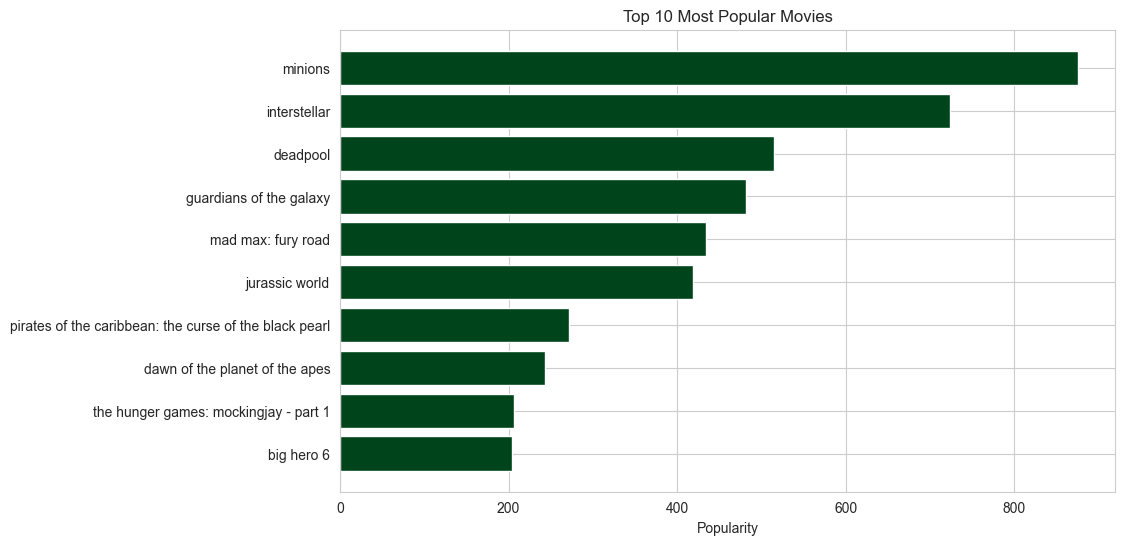

In [111]:
top_popular = df.nlargest(10, 'popularity')
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_popular['title_x'], top_popular['popularity'], color=plt.cm.PRGn(top_popular['popularity']/10))
plt.xlabel('Popularity')
plt.title('Top 10 Most Popular Movies')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest popularity at the top
plt.show()

top 10 movies in regards to rating

Most voted


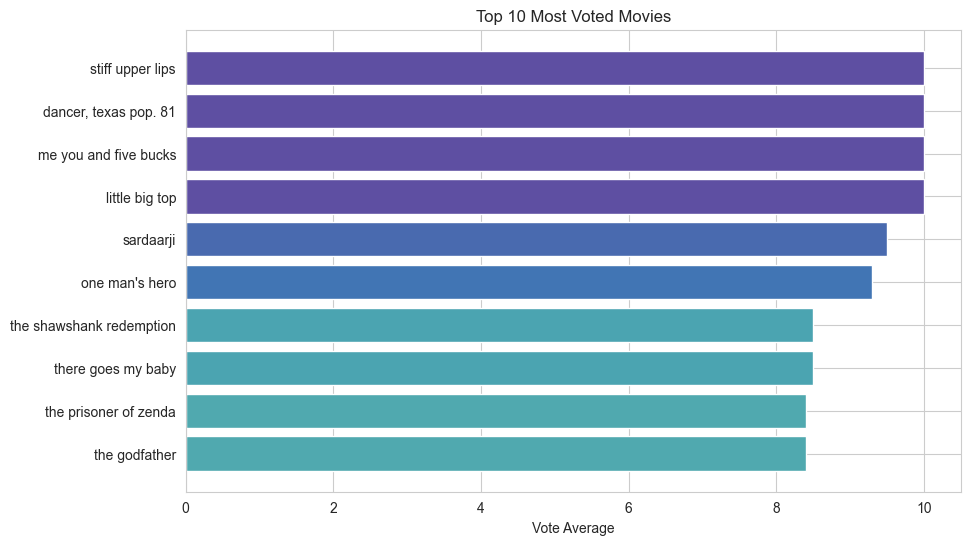

In [119]:
top = df.nlargest(10,'vote_average')
print('Most voted')
top[['title_x','year','vote_average', 'revenue']]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top['title_x'], top['vote_average'], color=plt.cm.Spectral(top['vote_average']/10))
plt.xlabel('Vote Average')
plt.title('Top 10 Most Voted Movies')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest vote average at the top
plt.show()

In [89]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

most profitable movies

In [228]:
most_profits = df.nlargest(10,'profit')
most_profits[['title_x','profit','year','vote_average']]

,title_x,profit,year,vote_average
0,avatar,2550965087,2009.0,7.2
25,titanic,1645034188,1997.0,7.5
28,jurassic world,1363528810,2015.0,6.5
44,furious 7,1316249360,2015.0,7.3
16,the avengers,1299557910,2012.0,7.4
7,avengers: age of ultron,1125403694,2015.0,7.3
124,frozen,1124219009,2013.0,7.3
546,minions,1082730962,2015.0,6.4
329,the lord of the rings: the return of the king,1024888979,2003.0,8.1
31,iron man 3,1015439994,2013.0,6.8


~ Generate word cloud

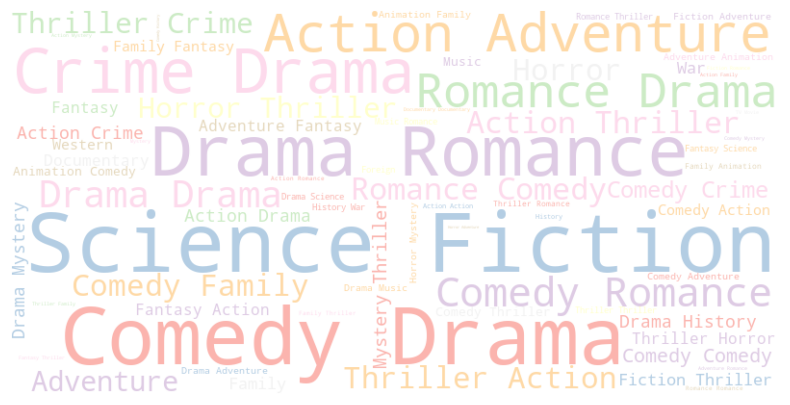

In [254]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

genres_list = df['genres'].explode().dropna()

genres_text = ' '.join(genres_list)
wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap='Pastel1').generate(genres_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Model dataset prepration

In [121]:
dataset = df.copy()

In [122]:
dataset.drop(columns=['id', 'title_x', 'original_language',  'genres', 'keywords', 'overview', 'production_companies', 'production_countries' , 'spoken_languages', 'cast', 'crew', 'revenue'], inplace=True)

split profit into 2 class profitable = 1 and unprofitable = 0

In [123]:
def profit_class(value):
    if  value >= 0:
        return 1
    else:
        return 0


dataset.loc[:, 'profit'] = dataset['profit'].apply(lambda x: profit_class(x))

# Machine Learning

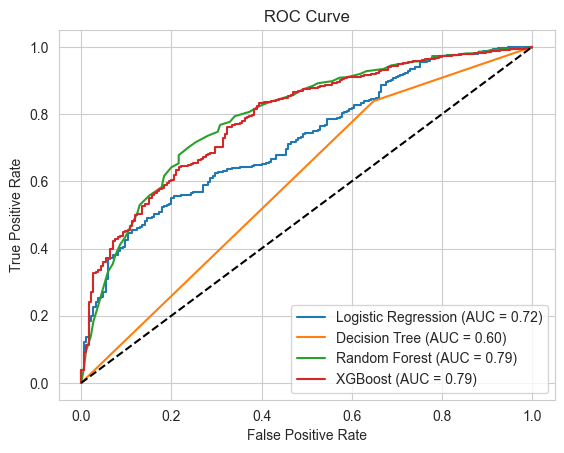

                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.811655   0.810867  1.000000  0.895557
Decision Tree        0.745057   0.844358  0.838918  0.841629
Random Forest        0.825182   0.839286  0.969072  0.899522
XGBoost              0.819979   0.852632  0.939433  0.893930

Feature Importance for Decision Tree:


NameError: name 'X' is not defined

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, make_scorer
import matplotlib.pyplot as plt

# Define the target variable
dataset['target'] = dataset['profit']

# Perform feature engineering and select features
# For simplicity, you can choose all numeric features
features = ['year', 'month', 'day', 'dow', 'budget', 'runtime', 'popularity', 'has_homepage', 'vote_average', 'vote_count']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], dataset['target'], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with default hyperparameters
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Define scoring metrics for GridSearchCV
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score), 
           'recall': make_scorer(recall_score), 
           'f1': make_scorer(f1_score)}

# Train and evaluate models with hyperparameter tuning using GridSearchCV
results = {}
tuned_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid={}, scoring=scoring, refit='accuracy', cv=5)
    grid_search.fit(X_train_scaled, y_train)
    tuned_model = grid_search.best_estimator_
    tuned_models[name] = tuned_model
    y_pred = tuned_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    
    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, tuned_model.predict_proba(X_test_scaled)[:,1])
    roc_auc = roc_auc_score(y_test, tuned_model.predict_proba(X_test_scaled)[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC-AUC curve for all models
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

# Additional analysis for tree-based models
for name, model in tuned_models.items():
    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        print(f"\nFeature Importance for {name}:")
        if hasattr(model, 'feature_importances_'):
            feature_importance = dict(zip(X.columns, model.feature_importances_))
            sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_feature_importance:
                print(f"{feature}: {importance:.4f}")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
dataset = df
# Select relevant features
features = ['title_x', 'genres', 'keywords', 'overview', 'cast']

# Combine text features into a single column
dataset['combined_features'] = dataset[features].apply(lambda x: ' '.join(map(str, x)), axis=1)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['combined_features'])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [79]:
def recommend_movies(movie_name, cos_similarity=cosine_sim):
    # Convert the movie title to lowercase and remove leading/trailing whitespace
    movie_name = movie_name.lower().strip()
    
    # Check if the movie title exists in the dataset
    if movie_name not in dataset['title_x'].str.lower().str.strip().values:
        return "Movie not found in the dataset"
    
    # Get the index of the movie in the dataset
    idx = dataset.loc[dataset['title_x'].str.lower().str.strip() == movie_name].index[0]
    
    # Compute similarity scores
    sim_scores = list(enumerate(cos_similarity[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 10 similar movies
    sim_scores = sim_scores[1:6]  # Exclude the first movie (itself)
    movie_indices = [i[0] for i in sim_scores]
    recommended_movies = dataset.iloc[movie_indices]
    
    # Explanation about common genres, cast, and keywords for each recommended movie
    explanation = ""
    for i, movie in enumerate(recommended_movies.itertuples(), 1):
        explanation += "{}\n".format(movie.title_x)
        common_genres = set(movie.genres) & set(recommended_movies.iloc[0].genres)
        if common_genres:
            explanation += "\tCommon Genres: {}\n".format(common_genres)
        common_keywords = set(movie.keywords) & set(recommended_movies.iloc[0].keywords)
        if common_keywords:
            explanation += "\tCommon Keywords: {}\n".format(common_keywords)
        common_cast = set(movie.cast) & set(recommended_movies.iloc[0].cast)
        if common_cast:
            explanation += "\tCommon Cast: {}\n".format(common_cast)
        explanation += "\n"
    
    return explanation


# Example usage
movie_title = "Quantum of Solace"
explanation = recommend_movies(movie_title)
print("Explanation for recommended movies for '{}' are:\n{}".format(movie_title, explanation))


Explanation for recommended movies for 'Quantum of Solace' are:
casino royale
	Common Genres: {'Action', 'Thriller', 'Adventure'}
	Common Keywords: {'poker', 'montenegro', 'free running', 'italy', 'terrorist', 'money', 'torture', 'british secret service', 'casino', 'banker'}
	Common Cast: {'Mads Mikkelsen', 'Judi Dench', 'Jeffrey Wright', 'Simon Abkarian', 'Giancarlo Giannini', 'Jesper Christensen', 'Daniel Craig', 'Isaach De Bankolé', 'Eva Green', 'Caterina Murino'}

never say never again
	Common Genres: {'Action', 'Thriller', 'Adventure'}
	Common Keywords: {'british secret service'}

spectre
	Common Genres: {'Action', 'Adventure'}
	Common Keywords: {'british secret service'}
	Common Cast: {'Daniel Craig'}

die another day
	Common Genres: {'Action', 'Thriller', 'Adventure'}
	Common Keywords: {'british secret service'}
	Common Cast: {'Judi Dench'}

skyfall
	Common Genres: {'Action', 'Thriller', 'Adventure'}
	Common Keywords: {'british secret service'}
	Common Cast: {'Judi Dench', 'Dani

In [49]:
data

,id,title_x,original_language,spoken_languages,genres,keywords,overview,production_companies,production_countries,year,...,runtime,popularity,has_homepage,cast,crew,vote_count,vote_average,profit,combined_features,tags
0,19995,avatar,en,"[en, es]",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009.0,...,162.0,150.437577,1,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, James Cameron, ...",11800,7.2,2550965087,avatar Action Adventure Fantasy Science Fictio...,culture clash future space war space colony so...
1,285,pirates of the caribbean: at world's end,en,[en],Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007.0,...,169.0,139.082615,1,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...",4500,6.9,661000000,pirates of the caribbean: at world's end Adven...,ocean drug abuse exotic island east india trad...
2,206647,spectre,en,"[fr, en, es, it, de]",Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,A cryptic message from Bond’s past sends him o...,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015.0,...,148.0,107.376788,1,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]",4466,6.3,635674609,spectre Action Adventure Crime spy based on no...,spy based on novel secret agent sequel mi6 bri...
3,49026,the dark knight rises,en,[en],Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012.0,...,165.0,112.312950,1,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Charles Roven, Christopher Nolan, Christopher...",9106,7.6,834939099,the dark knight rises Action Crime Drama Thril...,dc comics crime fighter terrorist secret ident...
4,49529,john carter,en,[en],Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",[Walt Disney Pictures],[United States of America],2012.0,...,132.0,43.926995,1,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Colin Wilson, Jim Morris, Lin...",2124,6.1,24139100,john carter Action Adventure Science Fiction b...,based on novel mars medallion space travel pri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,el mariachi,es,[es],Action Crime Thriller,united states–mexico barrier legs arms paper k...,El Mariachi just wants to play his guitar and ...,[Columbia Pictures],"[Mexico, United States of America]",1992.0,...,81.0,14.269792,0,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua...","[Robert Rodriguez, Robert Rodriguez, Carlos Ga...",238,6.6,1820920,el mariachi Action Crime Thriller united state...,united states–mexico barrier legs arms paper k...
4799,72766,newlyweds,en,[],Comedy Romance,,A newlywed couple's honeymoon is upended by th...,[],[],2011.0,...,85.0,0.642552,0,"[Edward Burns, Kerry Bishé, Marsha Dietlein, C...","[Edward Burns, Edward Burns, Edward Burns, Wil...",5,5.9,51742835,newlyweds Comedy Romance A newlywed couple's ...,Comedy Romance
4800,231617,"signed, sealed, delivered",en,[en],Comedy Drama Romance TV Movie,date love at first sight narration investigati...,"""Signed, Sealed, Delivered"" introduces a dedic...","[Front Street Pictures, Muse Entertainment Ent...",[United States of America],2013.0,...,120.0,1.444476,1,"[Eric Mabius, Kristin Booth, Crystal Lowe, Geo...","[Harvey Kahn, Martha Williamson, Scott Smith]",6,7.0,28751835,"signed, sealed, deliver